In [1]:
import numpy as np
np.random.seed(0)


class Layer(object):

    def __init__(self):
        self.parameters = list()

    def get_parameters(self):
        return self.parameters


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)

        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))


class Sequential(Layer):

    def __init__(self, layers=list()):
        super().__init__()

        self.layers = layers

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

In [2]:
class Tensor (object):

    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):

        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id

        self.creators = creators
        self.creation_op = creation_op
        self.children = {}

        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True

    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):

            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad

            # grads must not have grads of their own
            assert grad.autograd == False

            if(self.creators is not None and
               (self.all_children_grads_accounted_for() or
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)

                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)

                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)

                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))

                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())

                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))

                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))

                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))

                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))

    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)

    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)

    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))

    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)

        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)

    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")

        return Tensor(self.data.transpose())

    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))

    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))

    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])

    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)

        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()

        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)

    def __repr__(self):
        return str(self.data.__repr__())

    def __str__(self):
        return str(self.data.__str__())


class Tanh(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.tanh()


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.sigmoid()


class Embedding(Layer):
    def __init__(self, vocab_size, dim):
        super().__init__()

        self.vocab_size = vocab_size
        self.dim = dim

        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)

        self.parameters.append(self.weight)

    def forward(self, input):
        return self.weight.index_select(input)


class CrossEntropyLoss(object):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return input.cross_entropy(target)


class SGD(object):
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha

    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0

    def step(self, zero=True):

        for p in self.parameters:

            p.data -= p.grad.data * self.alpha

            if(zero):
                p.grad.data *= 0

In [3]:
x = Tensor(np.eye(5), autograd=True)
x.index_select(Tensor([[1,2,3],[2,3,4]])).backward()
print(x.grad)

[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1.]]


In [4]:
# data indices
data = Tensor(np.array([1,2,1,2]), autograd=True)

# target indices
target = Tensor(np.array([0,1,0,1]), autograd=True)

model = Sequential([Embedding(3,3), Tanh(), Linear(3,3), Tanh(), Linear(3,4)])
criterion = CrossEntropyLoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.1)

print(data)

for i in range(100):
    # Predict
    pred = model.forward(data)
    print("data", "\n", data, "\n", "target", "\n", target, "\n", pred)
    # Compare
    loss = criterion.forward(pred, target)

    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[1 2 1 2]
data 
 [1 2 1 2] 
 target 
 [0 1 0 1] 
 [[-0.10363227  0.00383646 -0.0748817   0.05136233]
 [-0.10832037  0.03863737  0.02301224  0.02962641]
 [-0.10363227  0.00383646 -0.0748817   0.05136233]
 [-0.10832037  0.03863737  0.02301224  0.02962641]]
1.4030881549887741
data 
 [1 2 1 2] 
 target 
 [0 1 0 1] 
 [[ 0.31377847 -0.16255518 -0.3086044  -0.43128882]
 [-0.02026546  0.02612241 -0.08075818 -0.37221923]
 [ 0.31377847 -0.16255518 -0.3086044  -0.43128882]
 [-0.02026546  0.02612241 -0.08075818 -0.37221923]]
1.1138552360044875
data 
 [1 2 1 2] 
 target 
 [0 1 0 1] 
 [[ 0.59299495 -0.25198941 -0.50797467 -0.74493671]
 [-0.05070496  0.09829529 -0.17564004 -0.58502446]
 [ 0.59299495 -0.25198941 -0.50797467 -0.74493671]
 [-0.05070496  0.09829529 -0.17564004 -0.58502446]]
0.9226806152949214
data 
 [1 2 1 2] 
 target 
 [0 1 0 1] 
 [[ 0.80545303 -0.31375797 -0.67824642 -0.98537696]
 [-0.16191867  0.23360501 -0.25473412 -0.68938864]
 [ 0.80545303 -0.31375797 -0.67824642 -0.98537696]
 [-0.

In [5]:
!pip install tensorflow

In [6]:
def calculate_accuracy(predictions, labels):
    predicted_classes = predictions.argmax(axis=1)
    correct = (predicted_classes == labels).sum()
    return correct / len(labels)

In [49]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Load and preprocess the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the images

# Flatten the images to fit into a linear layer
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Model structure for MNIST
model = Sequential([
    Linear(28*28, 128),  # First linear layer
    Tanh(),
    Linear(128, 64),     # Second linear layer
    Tanh(),
    Linear(64, 10)       # Output layer for 10 classes
])

criterion = CrossEntropyLoss()
optimizer = SGD(parameters=model.get_parameters(), alpha=0.01)

metadata = {"loss": [], "acc_train": [], "acc_test": []}

# Training loop
epochs = 4
batch_size = 32
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_accuracy_test = 0
    step = 0
    for i in range(0, len(x_train), batch_size):
        batch_data = Tensor(x_train[i:i+batch_size], autograd=True)
        batch_target = Tensor(y_train[i:i+batch_size], autograd=True)

        # Forward pass
        pred = model.forward(batch_data)
        # Compute accuracy
        accuracy = calculate_accuracy(pred.data, batch_target.data)
        # Compute loss
        loss = criterion.forward(pred, batch_target)
        # print(loss.data)
        # raise
        if (step % 100) == 0:
            random_indices = np.random.choice(len(y_test), size=128, replace=False).astype(int)
            # test_samples = [pred_test.data[i] for i in random_indices]
            # test_y_samples = [y_test.data[i] for i in random_]

            pred_test_np = np.array(pred_test.data)
            y_test_np = np.array(y_test.data)

            pred_test = model.forward(Tensor(x_test, autograd=False))
            accuracy = calculate_accuracy(pred.data, batch_target.data)
            accuracy_test = calculate_accuracy(pred_test_np[random_indices], y_test_np[random_indices])

            metadata["loss"].append(loss.data)
            metadata["acc_train"].append(accuracy)
            metadata["acc_test"].append(accuracy_test)

            epoch_loss += loss.data
            epoch_accuracy += accuracy
            epoch_accuracy_test += accuracy_test

        # Backward pass and optimization
        loss.backward(Tensor(np.ones_like(loss.data)))
        optimizer.step()
        step += 1

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / step * 100}, Accuracy Train: {epoch_accuracy / step * 100}, Accuracy Test: {epoch_accuracy_test / step * 100}")

# Testing on a sample from test set
test_data = Tensor(x_test[:5], autograd=True)
test_pred = model.forward(test_data)
print("Predictions:", test_pred.data.argmax(axis=1))
print("Actual:", y_test[:5])

Epoch 1/4, Loss: 0.3331671001800652, Accuracy Train: 0.8983333333333333, Accuracy Test: 0.9079166666666666
Epoch 2/4, Loss: 0.10506883797212319, Accuracy Train: 0.98, Accuracy Test: 0.9724999999999999
Epoch 3/4, Loss: 0.06405394750962086, Accuracy Train: 0.9950000000000001, Accuracy Test: 0.98125
Epoch 4/4, Loss: 0.04307627642820923, Accuracy Train: 1.0016666666666667, Accuracy Test: 0.9820833333333334
Predictions: [7 2 1 0 4]
Actual: [7 2 1 0 4]


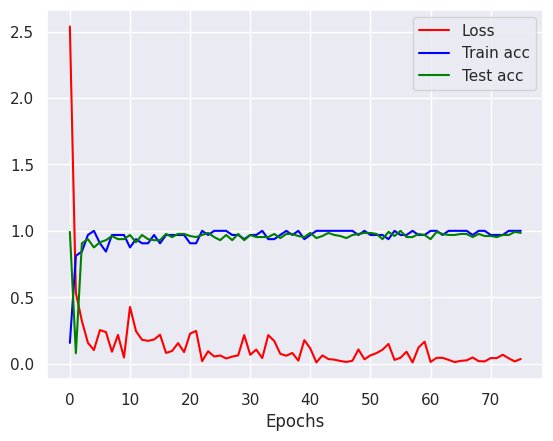

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.plot(np.array(metadata["loss"]) , label='Loss', color='red')
plt.plot(np.array(metadata["acc_train"]), label='Train acc', color='blue')
plt.plot(np.array(metadata["acc_test"]), label='Test acc', color='green')
# plt.title('Training Loss')
plt.xlabel('Epochs')
# plt.ylabel('Loss')
plt.grid(True)
plt.legend()